Importing required libraries

In [61]:
import math
import matplotlib.pyplot as plt
import subprocess
from tabulate import tabulate

Creating separate pcap files for each source IP using 'assignment.pcap' file

In [62]:
'''cmd_224 = 'tshark -r assignment.pcap  -w out_224.pcap -Y "ip.src == 192.168.1.224" -t ad'
cmd_57 = 'tshark -r assignment.pcap  -w out_57.pcap -Y "ip.src == 192.168.1.57" -t ad'
cmd_77 = 'tshark -r assignment.pcap  -w out_77.pcap -Y "ip.src == 192.168.1.77" -t ad'
cmd_141 = 'tshark -r assignment.pcap  -w out_141.pcap -Y "ip.src == 192.168.1.141" -t ad'
cmd_139 = 'tshark -r assignment.pcap  -w out_139.pcap -Y "ip.src == 192.168.1.139" -t ad'

subprocess.run(cmd_224, shell=True)
subprocess.run(cmd_57, shell=True)
subprocess.run(cmd_77, shell=True)
subprocess.run(cmd_141, shell=True)
subprocess.run(cmd_139, shell=True)'''


'cmd_224 = \'tshark -r assignment.pcap  -w out_224.pcap -Y "ip.src == 192.168.1.224" -t ad\'\ncmd_57 = \'tshark -r assignment.pcap  -w out_57.pcap -Y "ip.src == 192.168.1.57" -t ad\'\ncmd_77 = \'tshark -r assignment.pcap  -w out_77.pcap -Y "ip.src == 192.168.1.77" -t ad\'\ncmd_141 = \'tshark -r assignment.pcap  -w out_141.pcap -Y "ip.src == 192.168.1.141" -t ad\'\ncmd_139 = \'tshark -r assignment.pcap  -w out_139.pcap -Y "ip.src == 192.168.1.139" -t ad\'\n\nsubprocess.run(cmd_224, shell=True)\nsubprocess.run(cmd_57, shell=True)\nsubprocess.run(cmd_77, shell=True)\nsubprocess.run(cmd_141, shell=True)\nsubprocess.run(cmd_139, shell=True)'

Function which takes pcap file location, source IP and time interval in ms (default=100)
Returns the amount of data transferred by the specified source IP in each interval of the given duration as a list.

In [63]:
def get_data_transfer_intervals(pcap_location, ip_src, interval_ms=100):
    #creating a packet filter for tshark
    packet_filter=f"frame.len==1514 && ip.src=={ip_src}"

    #tshark command which gets relative time of the filtered packets
    cmd = f"tshark -r {pcap_location} -Y '{packet_filter}' -T fields -e tcp.time_relative"

    #running the command and getting the output
    output = subprocess.run(cmd,shell=True,capture_output=True,text=True)

    #getting the relative time of the packets and converting it to milliseconds
    time_list = list(output.stdout.strip().split('\n'))
    time_list_ms = []
    for i in time_list:
        if i == '':
            continue
        time_list_ms.append(float(i)*1000)



    #creating a list of 0s for the intervals (100 seconds divided into intervals of given duration)
    data_transfers_intervals = [0 for x in range(math.ceil(100000/interval_ms))]

    #adding the data transfer of each packet to the corresponding interval
    for timestamp in time_list_ms:
        index = int(timestamp//interval_ms)
        #size of each packet is 1514 bytes
        data_transfers_intervals[index] += 1514

    #returning the data transfer in each interval in bytes
    return [x if x==0 else x/8 for x in data_transfers_intervals]



Creating a list of data transfer in each interval for each pcap file
(30s approximate runtime)

In [64]:
set_interval_ms=100

plot_list_77 = get_data_transfer_intervals('out_77.pcap','192.168.1.77',set_interval_ms)
plot_list_57 = get_data_transfer_intervals('out_57.pcap','192.168.1.57',set_interval_ms)
plot_list_141 = get_data_transfer_intervals('out_141.pcap','192.168.1.141',set_interval_ms)
plot_list_139 = get_data_transfer_intervals('out_139.pcap','192.168.1.139',set_interval_ms)
plot_list_224 = get_data_transfer_intervals('out_224.pcap','192.168.1.224',set_interval_ms)

#create a list of all the data transfer lists
plot_list_all = [plot_list_77,plot_list_139 , plot_list_141, plot_list_224, plot_list_57]

Function which takes a list of lists returned by get_data_transfer_intervals()
It plots a time series chart for data transferred by each IP in given transfer intervals

In [65]:
def plot_timeline(plot_list_all, interval_ms=100):
    #interval_ms is the interval in milliseconds
    #data_transfer_intervals is the list of data transfer intervals
    #plotting the data transfer intervals
    cmap = plt.get_cmap('tab10')
    ip_list=['192.168.1.77','192.168.1.139','192.168.1.141','192.168.1.224','192.168.1.57']
    fig, axes = plt.subplots(nrows=len(plot_list_all), ncols=1,figsize=(20,10),sharex=True,constrained_layout=True)
    i=0
    for data_transfer_intervals in plot_list_all:

        axes[i].set_ylim(-5000,max(max(sub_l) for sub_l in plot_list_all))
        axes[i].plot([x*(interval_ms/1000) for x in range(len(data_transfer_intervals))], data_transfer_intervals,color=cmap(i),label=ip_list[i])
        axes[i].legend(loc="upper left")
        i+=1
        
    
    axes[2].set_ylabel('Bandwidth (Bytes/sec)')
    axes[-1].set_xlabel('Time (sec)')
    plt.show()


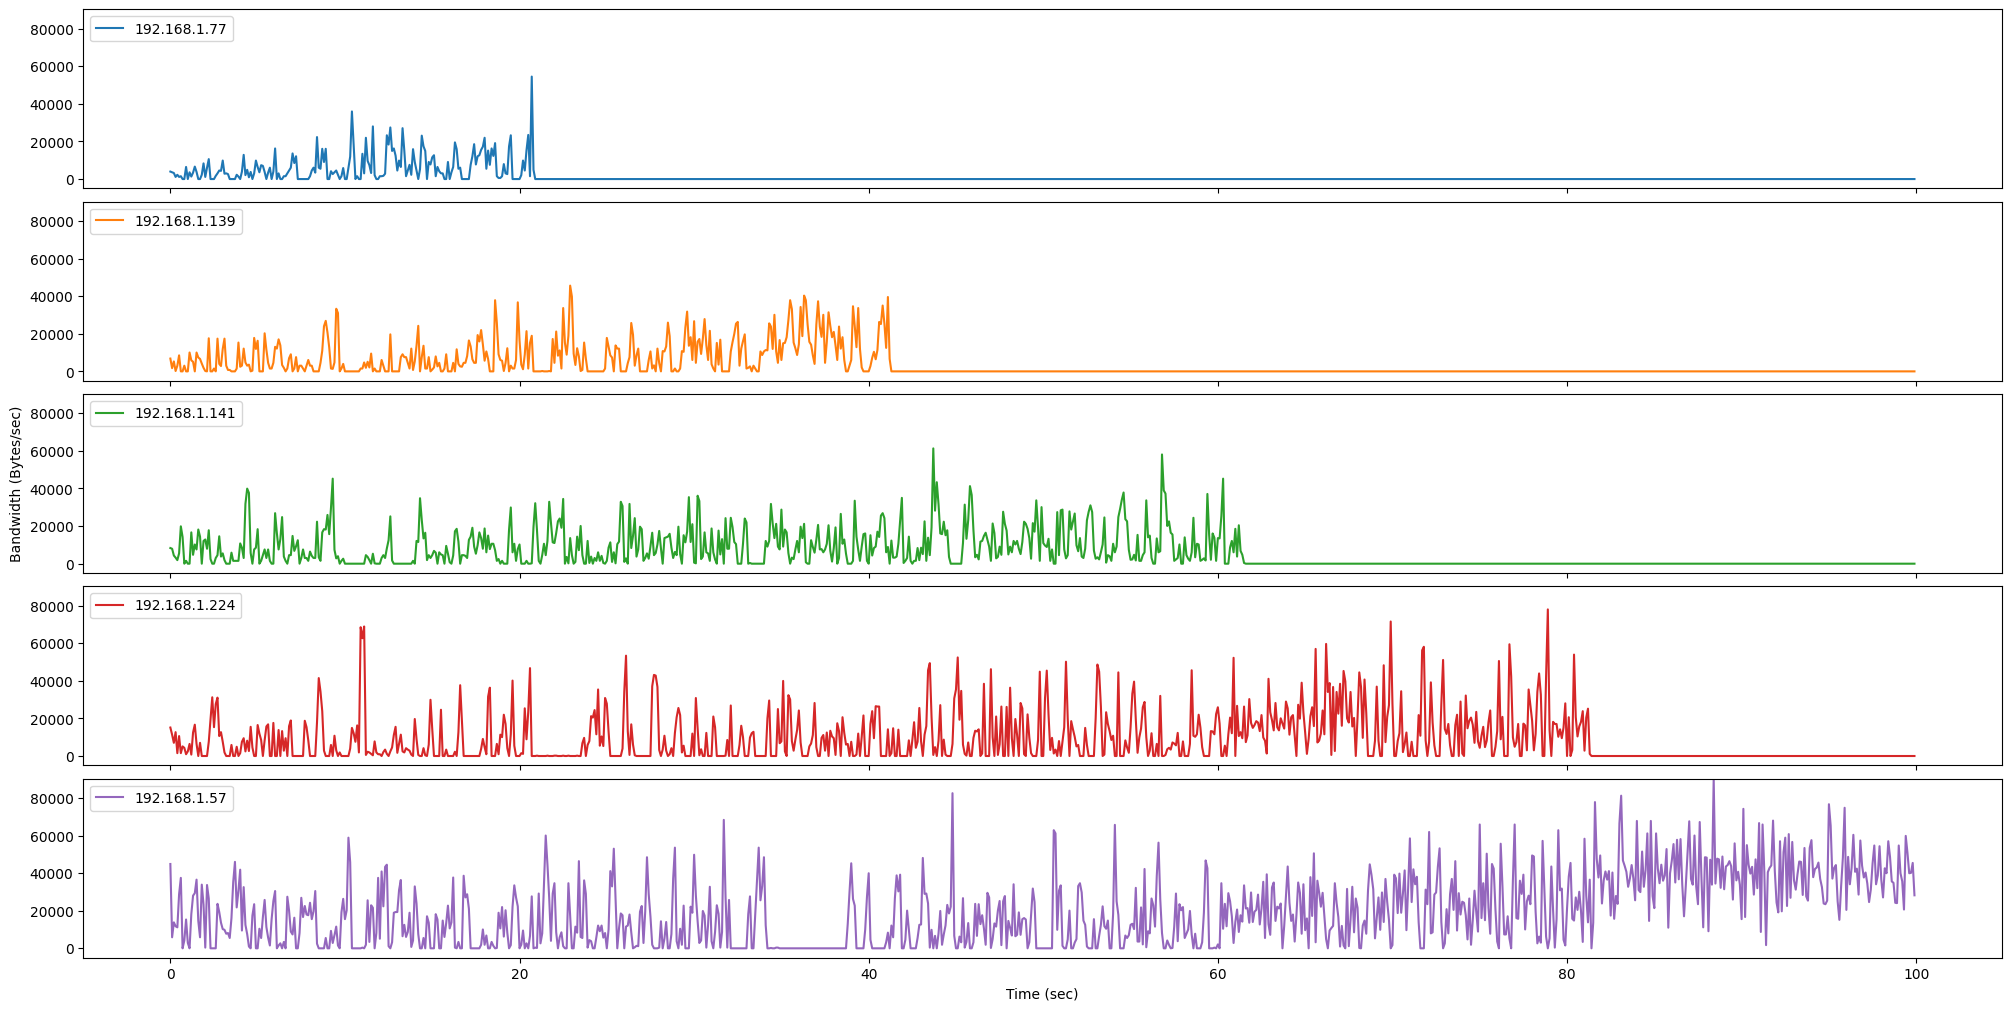

In [66]:
plot_timeline(plot_list_all,set_interval_ms)

Function to plot the total throughput of all IPs combined

In [67]:
def plot_total_throughput(plot_list_all, interval_ms=100):
    total_throughput = [0 for x in range(len(plot_list_all[0]))]
    for plot_list in plot_list_all:
        for i in range(len(plot_list)):
            total_throughput[i] += plot_list[i]
    plt.figure(figsize=(30,3))
    plt.plot([x*(interval_ms/1000) for x in range(len(total_throughput))], total_throughput)
    plt.title('Total Throughput')
    plt.xlabel('Time (s)')
    plt.xlim(0,100)
    plt.ylabel('Bandwidth (Bytes/sec)')
    plt.show()

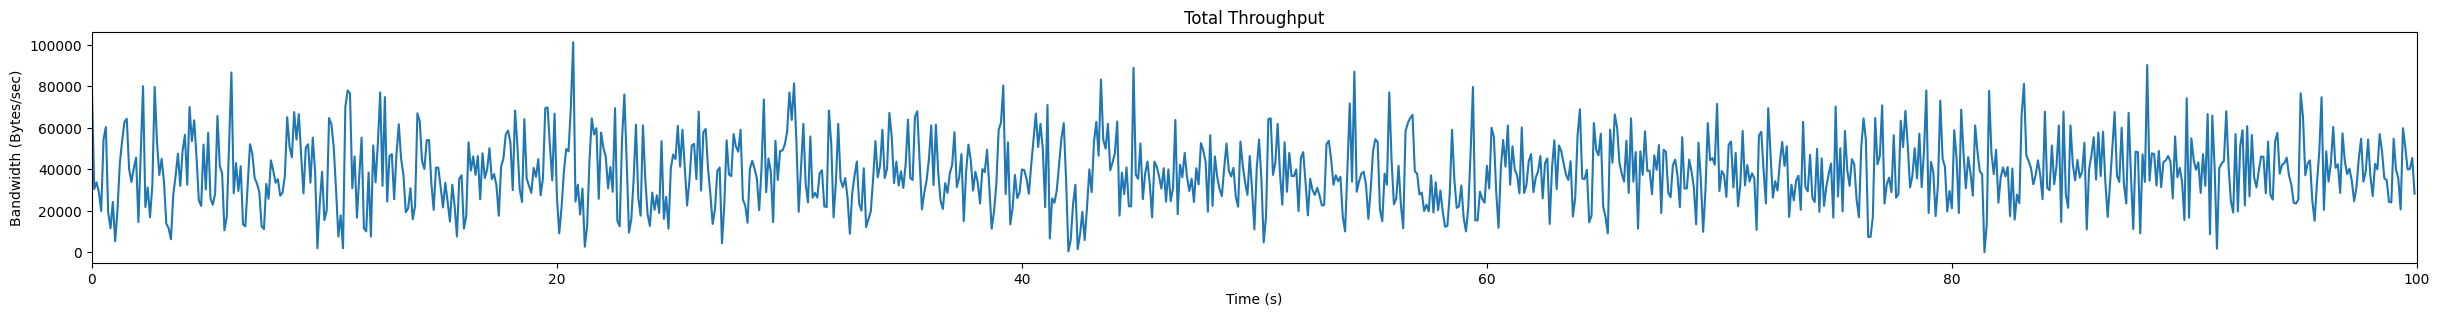

In [68]:
plot_total_throughput(plot_list_all,set_interval_ms)

Function which calculates the throughput fraction of each source IP in each interval of 20 seconds
Returns a list of lists. Each list has information of data transferred by an IP divided into intervals
(2m 50s approximate runtime)

In [69]:
def throughput_fraction_analysis():
    #list of source IPs in order of the plot_list_all
    ip_list=['192.168.1.77','192.168.1.139','192.168.1.141','192.168.1.224','192.168.1.57']
    
    ip_throughputs = []

    #Iterating through each source IP
    for src_ip in ip_list:
        throughputs = []

        #Iterating through each 20 second interval
        for i in range(5):

            #creating a packet filter for tshark to get the packets of an ip in the relevant interval
            packet_filter = f"frame.len==1514 && ip.src=={src_ip} && tcp.time_relative>={i*20} && tcp.time_relative<{(i+1)*20}"

            #tshark command which gets the number of packets in the interval
            cmd = f"tshark -r assignment.pcap -Y '{packet_filter}' | wc -l"
            output = subprocess.run(cmd,shell=True,capture_output=True,text=True)

            #appending the number of packets in the interval to the throughputs list
            throughputs.append(int(output.stdout.strip())*1514)

        #appending the throughputs list of the ip to the ip_throughputs list
        ip_throughputs.append(throughputs)
        
    return ip_throughputs


ip_throughputs = throughput_fraction_analysis()

In [70]:
#normalizing the throughputs
ip_throughputs_transposed = list(map(list, zip(*ip_throughputs)))
ip_throughputs_transposed_normalized = [[x/sum(y) for x in y] for y in ip_throughputs_transposed]
ip_throughputs_normalized = list(map(list, zip(*ip_throughputs_transposed_normalized)))

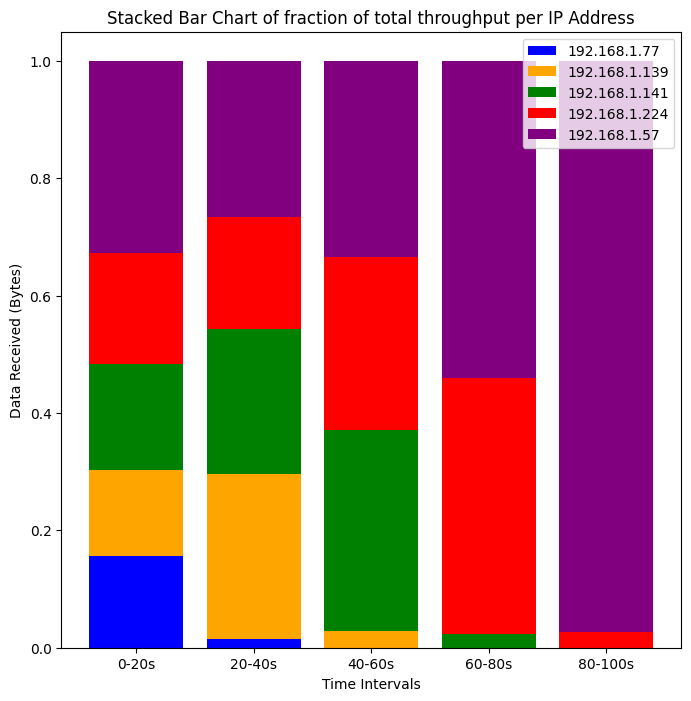

+---------------+---------+----------+----------+----------+-----------+
| IP Address    |   0-20s |   20-40s |   40-60s |   60-80s |   80-100s |
+===============+=========+==========+==========+==========+===========+
| 192.168.1.77  |   0.157 |    0.015 |    0     |    0     |     0     |
+---------------+---------+----------+----------+----------+-----------+
| 192.168.1.139 |   0.145 |    0.281 |    0.029 |    0     |     0     |
+---------------+---------+----------+----------+----------+-----------+
| 192.168.1.141 |   0.182 |    0.247 |    0.343 |    0.023 |     0     |
+---------------+---------+----------+----------+----------+-----------+
| 192.168.1.224 |   0.188 |    0.191 |    0.294 |    0.436 |     0.027 |
+---------------+---------+----------+----------+----------+-----------+
| 192.168.1.57  |   0.328 |    0.266 |    0.334 |    0.541 |     0.973 |
+---------------+---------+----------+----------+----------+-----------+


In [71]:
ip_list=['192.168.1.77','192.168.1.139','192.168.1.141','192.168.1.224','192.168.1.57']

#Each row represents an IP address, each column represents a time interval
data = ip_throughputs_normalized

time_intervals = ["0-20s", "20-40s", "40-60s", "60-80s", "80-100s"]
num_ips = len(data)

# Colors for each stacked segment
colors = ["blue", "orange", "green", "red", "purple"]

# Plot stacked bars
fig, ax = plt.subplots(figsize=(8, 8))

# Stack each row onto the previous
bottom = [0] * len(time_intervals)  # Initialize bottom to zero

for i in range(num_ips):
    ax.bar(time_intervals, data[i], bottom=bottom, label=ip_list[i], color=colors[i])
    bottom = [bottom[j] + data[i][j] for j in range(len(time_intervals))]  # Update bottom for next stack


ax.set_xlabel("Time Intervals")
ax.set_ylabel("Data Received (Bytes)")
ax.set_title("Stacked Bar Chart of fraction of total throughput per IP Address")
ax.legend()

plt.show()

#Printing the data in a tabular format
headers = ["IP Address", "0-20s", "20-40s", "40-60s", "60-80s", "80-100s"]
table = []
for i in range(num_ips):
    table.append([ip_list[i]] + [round(x,3) for x in data[i]])

print(tabulate(table, headers, tablefmt="grid"))